# <center>Skill Factory Year One Final Project
## <center>Прогнозирование цен на недвижимость

## 1) Обзор проекта
Разработайте сервис для прогнозирования стоимости объектов недвижимости на основе истории предложений.

## 2) Предварительный анализ данных - Часть 1

In [1]:
# !pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 9.7 MB/s eta 0:00:00


In [2]:
# Импорт библиотек

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
from lightgbm import LGBMRegressor
from scipy import stats
from scipy.stats import shapiro
from sklearn import metrics, preprocessing
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor,
                              StackingRegressor)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

#### Обзор данных

In [3]:
# Настроим различные пути к файлу.
W_pth = r'data.csv.zip' # Windows path.
L_pth = '/home/mike/Documents/Coding/Data/Final project/data.csv/data.csv.zip' # Linux path.
G_pth = '/content/data.csv.zip' # Google path.

if os.path.exists(L_pth):
    data = pd.read_csv(L_pth)

elif os.path.exists(W_pth):
    data = pd.read_csv(W_pth)

elif os.path.exists(G_pth):
    data = pd.read_csv(G_pth)

else:
    print('Проверте верность пути нахождения файла.')

In [4]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


**Названия столбцов**
1. status
2. private pool
3. propertyType
4. street
5. baths
6. homeFacts
7. fireplace
8. city
9. schools
10. sqft
11. zipcode
12. beds
13. state
14. stories
15. mls-id
16. PrivatePool
17. MlsId
18. target

In [5]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [6]:
data.shape

(377185, 18)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [8]:
# Поиск дубликатов.

print('Number of full duplicates: {}'.format(data.duplicated().sum()))

Number of full duplicates: 50


In [9]:
# Удаление дубликатов.

data.drop_duplicates(inplace=True)
print('Number of lines without duplicates: {}'.format(data.shape))

Number of lines without duplicates: (377135, 18)


In [10]:
# Проверим данные на пропуски.

null_data = data.isnull().sum()
display(null_data[null_data > 0])

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
fireplace       274023
city                34
sqft             40550
beds             91254
stories         150673
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

In [11]:
# У нас есть 2480 отсутствующих значений в "target" (что составляет около 0,65% от общей базы данных).
# Они бесполезны - удалим их.

data.drop(data[data.target.isna()].index, inplace=True)
data.shape

(374655, 18)

---
**target**

In [12]:
data['target'] = data['target'].apply(lambda x: str(x).lower()) # Приведём все значения целевой переменной к нижнему регистру.
data['target'] = data['target'].astype(str) # Преобразуем все значения в строковый вид.
data['target'].value_counts().head() # Выведем самые частые значения.

$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
Name: target, dtype: int64

In [13]:
# Удалим все ненужные символы.
data['target'] = data['target'].replace(r'[^\d]', '', regex=True)

# Преобразуем в числовой тип.
data['target'] = pd.to_numeric(data['target'], errors='coerce')
data['target'].value_counts().head()

225000    1806
275000    1650
250000    1644
350000    1641
325000    1562
Name: target, dtype: int64

In [14]:
# Удалим аномально малые значения цены.
data = data[data['target'] >= 1000]

In [15]:
# Тест Шапиро-Уилка на нормальность.

stat, p = shapiro(data['target'])

if p > 0.05:
    print("Целевой столбец, скорее всего, распределен нормально.")
else:
    print("Целевой столбец не распределён нормально.")

Целевой столбец не распределён нормально.


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


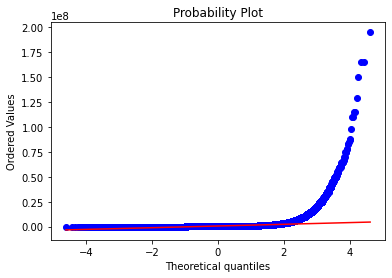

In [16]:
# Используем график Q-Q ("график квантиль-квантиль"), чтобы визуально проверить, нормально ли распределены значения в data['target'].

# Извлекаем значения из столбца 'target'.
values = data['target'].values

# Используем функцию scipy.stats.probplot для создания графика Q-Q
stats.probplot(values, dist="norm", plot=plt)

plt.show()

Целевые значения распределяются ненормально. Мы поработаем с этим позже.

Обычно на этом этапе мы создаем несколько графиков для иллюстрации и анализа данных. Однако даже числовые объекты представлены здесь в виде строк. Поэтому сначала мы проведем предварительную обработку данных, а затем рассмотрим их более подробно.

## 3) Предварительная обработка данных.

**status**

In [17]:
data['status'] = data['status'].apply(lambda x: str(x).lower())
data['status'] = data['status'].astype(str)
data['status'].describe()

count       374554
unique         150
top       for sale
freq        199511
Name: status, dtype: object

In [18]:
data['status'].value_counts(dropna=False)

for sale                   199511
active                     105187
nan                         39247
foreclosure                  5981
new construction             5458
                            ...  
coming soon: nov 8.             1
coming soon: oct 29.            1
coming soon: dec 15.            1
pending w/backup wanted         1
coming soon: dec 23.            1
Name: status, Length: 150, dtype: int64

In [19]:
# ###############################################################################
# status_list = list(data['status'].unique()) # Думаю нужно добавить в списки отсутствующие слова, а также пустую строку.

# status_list
# ###############################################################################

In [20]:
# #################################################################################
# def find_Whole_Word(w): # Функция, находящая слова только от пробела до пробела.
#   return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

# def find_word(word): # Находим только целые слова.
#   '''
#   Функция находит в каждой строке признака конкретное целое слово или 
#   словосочетание.
#   '''
#   cnt = 0
#   list_ = []
#   for str_ in status_list:
#     if find_Whole_Word(word)(str_):
#       list_.append(str_)
#       cnt += 1

#   # print(f'Слово встречается {cnt} раз.')
#   # print(list_)

#   if cnt == 0:
#     return False
#   else:
#     return True

# print(find_word('p'))
# #####################################################################################

In [21]:
# ##################################################################################
# # Преобразуем значения 'status'.
# def status_optimisation(status):
#     # Создадим списки слов для поиска.
#     contingent_list = ['contingent', 'contingencies', 'contingency', 'pending',
#                    'continue', 'contract', 'backups', 'p', 'c', 'pi', 'ct',
#                    'due diligence period', 'p pending sale', 'closed', 'pf',
#                    'accepted offer', 'ps', 'backup']
#     active_list = ['active', 'for sale', 'lease/purchase', 'back on market',
#                    'listing extended', 're activated', 'reactivated']
#     new_list = ['new', 'coming soon']
#     foreclosure_list = ['foreclosure', 'pre-foreclosure']
    
#     # Проверим содержат ли строки в status какое-либо из слов в списках.
#     if status:
#       for word in contingent_list:
#           if find_word(word):
#             return 'contingent'

#       for word in active_list:
#           if find_word(word):
#             return 'active'

#       for word in new_list:
#           if find_word(word):
#             return 'new'

#       for word in foreclosure_list:
#           if find_word(word):
#             return 'foreclosure'
            
#       if find_word('rent'):
#             return 'rent'

#       else:
#             return 'no data'
#     else:
#         return 'no data'
    
# data['status_1'] = data['status'].apply(lambda x: status_optimisation(x))
# data['status_1'].value_counts()
# ################################################################################Это работает не правильно.

In [22]:
# foreclosure_list = ['foreclosure', 'pre-foreclosure']

# for word in foreclosure_list:
#   if find_word(word):
#     print(word)

In [23]:
# contingent_list = ['contingent', 'contingencies', 'contingency', 'pending',
#                    'continue', 'contract', 'backups', 'p', 'c', 'pi', 'ct',
#                    'due diligence period', 'p pending sale', 'closed', 'pf',
#                    'accepted offer', 'ps', 'backup']
# print(len(contingent_list))
# for word in contingent_list:
#   if find_word(word):
#     print(word)

In [24]:
# # Отредактировано
# # Преобразуем значения 'status'.
# def status_optimisation(status):
#     # Создадим списки слов для поиска.
#     contingent_list = ['contingent', 'contingencies', 'contingency', 'pending',
#                    'continue', 'contract', 'backups', 'p', 'c', 'pi', 'ct',
#                    'due diligence period', 'p pending sale', 'closed', 'pf',
#                    'accepted offer', 'ps', 'backup']
#     active_list = ['active', 'for sale', 'lease/purchase', 'back on market',
#                    'listing extended', 're activated', 'reactivated']
#     new_list = ['new', 'coming soon']
#     foreclosure_list = ['foreclosure', 'pre-foreclosure']
    
#     # Проверим содержат ли строки в status какое-либо из слов в списках.



#     if status:
#         if 'rent' in status:
#             return 'rent'
#         elif any(word in status for word in foreclosure_list):
#             return 'foreclosure'
#         elif any(word in status for word in contingent_list):
#             return 'contingent'
#         elif any(word in status for word in active_list):
#             return 'active'
#         elif any(word in status for word in new_list):
#             return 'new'
# '''
# Поскольку мы не можем предусмотреть все слова в проверочных словарях, 
# то я решил создать словарь из значений в признаке, и эти значения также
# сравнить с проверочными словарями.
# '''
#         elif any(word in status_list for word in foreclosure_list): ########################
#             return 'foreclosure'
#         elif any(word in status_list for word in contingent_list):  ########################
#             return 'contingent'
#         elif any(word in status_list for word in active_list):      ########################
#             return 'active'
#         elif any(word in status_list for word in new_list):         ######################## 
#             return 'new'

#         else:
#             return 'no data'
#     else:
#         return 'no data'
    
# data['status'] = data['status'].apply(lambda x: status_optimisation(x))
# data['status'].value_counts()
# ###############################################################################

In [25]:
# foreclosure_list = ['foreclosure', 'pre-foreclosure']
# any(word in status_list for word in foreclosure_list)

In [26]:
# Преобразуем значения 'status'.
def status_optimisation(status):
    # Создадим списки слов для поиска.
    contingent_list = ['contingent', 'contingencies', 'contingency', 'pending',
                   'continue', 'contract', 'backups', 'p', 'c', 'pi', 'ct',
                   'due diligence period', 'p pending sale', 'closed', 'pf',
                   'accepted offer', 'ps', 'backup']
    active_list = ['active', 'for sale', 'lease/purchase', 'back on market',
                   'listing extended', 're activated', 'reactivated']
    new_list = ['new', 'coming soon']
    foreclosure_list = ['foreclosure', 'pre-foreclosure']
    
    # Проверим содержат ли строки в status какое-либо из слов в списках.
    if status:
        if 'rent' in status:
            return 'rent'
        elif any(word in status for word in foreclosure_list):
            return 'foreclosure'
        elif any(word in status for word in contingent_list):
            return 'contingent'
        elif any(word in status for word in active_list):
            return 'active'
        elif any(word in status for word in new_list):
            return 'new'
        else:
            return 'no data'
    else:
        return 'no data'
    
data['status'] = data['status'].apply(lambda x: status_optimisation(x))
data['status'].value_counts()

active         199539
contingent     125427
no data         39247
foreclosure      9264
new               690
rent              387
Name: status, dtype: int64

---
**private pool & PrivatePool**

In [27]:
data['private pool'] = data['private pool'].apply(lambda x: str(x).lower())
data['private pool'].describe()

count     374554
unique         2
top          nan
freq      370403
Name: private pool, dtype: object

In [28]:
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: str(x).lower())
data['PrivatePool'].describe()

count     374554
unique         2
top          nan
freq      334435
Name: PrivatePool, dtype: object

In [29]:
data['private pool'].unique()

array(['nan', 'yes'], dtype=object)

In [30]:
data['PrivatePool'].unique()

array(['nan', 'yes'], dtype=object)

In [31]:
# Объединим столбцы.
data['private pool'] = data['private pool'].apply(lambda x: 1 if x == 'yes' else 0)
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if x == 'yes' else 0)
data['PrivatePool'] = data['private pool'] | data['PrivatePool']
data['PrivatePool'] = data['PrivatePool'].astype('int')

---
**propertyType**

In [32]:
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).lower())
data['propertyType'] = data['propertyType'].astype(str)
data['propertyType'].describe()

count                 374554
unique                  1272
top       single-family home
freq                   91355
Name: propertyType, dtype: object

In [33]:
data['propertyType'].value_counts(dropna=False)

single-family home                                             91355
single family                                                  61884
condo                                                          42364
nan                                                            34538
single family home                                             31724
                                                               ...  
contemporary, farmhouse                                            1
2 stories, traditional, mediterranean, texas hill country          1
1 story, contemporary, traditional, mediterranean                  1
loft, warehouse                                                    1
bilevel, converted dwelling, loft with bedrooms, condo/unit        1
Name: propertyType, Length: 1272, dtype: int64

In [34]:
# Преобразуем значения 'propertyType'.
def propertyType_optimisation(prop_type):
    # Создадим списки слов для поиска.
    house_list = ['house', 'family', 'home', 'traditional', 'stories', 'story', 
                  'transitional', 'florida', 'bungalow', 'cape cod', 'mediterranean']
    townhouse_list = ['townhouse', 'multiplex', 'duplex', 'triplex', 'urban', 'fourplex',
                      'attached', 'detached','split-entry']
    condo_list = ['condo', 'apartment', 'cooperative', 'high rise', 'multiple', 'coop',
                  'co-op', 'loft', 'flat', 'penthouse']
    ranches_list = ['ranches', 'rancher', 'ranch', 'farm', 'miscellaneous']
    
    # Проверим содержат ли строки в propertyType какое-либо из слов в списках.
    if prop_type:
        if any(word in prop_type for word in house_list):
            return 'house'
        elif any(word in prop_type for word in townhouse_list):
            return 'townhouse'
        elif any(word in prop_type for word in condo_list):
            return 'condo'
        elif any(word in prop_type for word in ranches_list):
            return 'ranches'
        elif 'other' in prop_type:
            return 'other'
        elif 'contemporary' in prop_type:
            return 'contemporary'
        elif 'land' in prop_type:
            return 'land'
        elif 'commercial' in prop_type:
            return 'other'
        elif 'mobile' in prop_type:
            return 'mobile'
        elif 'nan' in prop_type:
            return 'no data'
        else:
            return 'house'
    else:
        return 'no data'
    
data['propertyType'] = data['propertyType'].apply(lambda x: propertyType_optimisation(x))
data['propertyType'].value_counts()

house           248691
condo            49504
no data          34538
land             31404
contemporary      2760
mobile            2670
ranches           2422
townhouse         1911
other              654
Name: propertyType, dtype: int64

---
**street**

In [35]:
data['street'] = data['street'].apply(lambda x: str(x).lower())
data['street'].describe()

count                    374554
unique                   333851
top       address not disclosed
freq                        672
Name: street, dtype: object

In [36]:
data['street'].value_counts().head(10)

address not disclosed    672
undisclosed address      515
(undisclosed address)    391
address not available    175
unknown address           72
2103 e state hwy 21       57
11305 gulf fwy            54
17030 youngblood rd.      38
ne 58th cir               34
9470 lancaster rd. sw     32
Name: street, dtype: int64

In [37]:
# Преобразуем значения 'street'.
def street_optimisation(address):
    # Создадим списки слов для поиска.
    drive_list = ['drive', 'dr', 'edr', 'ndr', 'sdr', 'wdr']
    lane_list = ['lane', 'ln', 'eln', 'nln', 'sln', 'wln', 'laneway', 'lnwy']
    way_list = ['way', 'freeway', 'fwy', 'highway', 'hwy', 'driveway', 'dvwy', 
                'expressway', 'exp', 'fairway', 'fawy', 'footway', 'ftwy',
                'motorway', 'mtwy', 'parkway', 'pkwy', 'pwy', 'pathway', 'pway']
    
    # Проверим содержат ли строки в street какое-либо из слов в списках.
    if address:
        if 'address' in address: return 'no data'
        elif 'street' in address: return 'street'
        elif 'st' in address: return 'street'
        elif any(word in address for word in drive_list):
            return 'drive'
        elif any(word in address for word in lane_list):
            return 'lane'
        elif any(word in address for word in way_list):
            return 'way'
        elif 'avenue' in address: return 'avenue'
        elif 'ave' in address: return 'avenue'
        elif 'rd' in address: return 'road'
        elif 'road' in address: return 'road'
        elif 'blvd' in address: return 'blvd'
        elif 'circle' in address: return 'circle'
        elif 'cir' in address: return 'circle'
        elif 'ct' in address: return 'court'
        elif 'court' in address: return 'court'
        elif 'pl' in address: return 'place'
        elif 'place' in address: return 'place'
        else:
            return 'other'
    else:
        return 'no data'

data['street'] = data['street'].apply(lambda x: street_optimisation(x))
data['street'].value_counts().head(50)

street     109836
drive       59737
avenue      58525
road        33303
other       27129
lane        21636
court       15401
place       14757
way         13208
blvd        11827
circle       7362
no data      1833
Name: street, dtype: int64

---
**baths**

In [38]:
data['baths'] = data['baths'].apply(lambda x: str(x).lower())
data['baths'].describe()

count     374554
unique       225
top          nan
freq      105275
Name: baths, dtype: object

In [39]:
data['baths'].value_counts().head(10)

nan             105275
2 baths          52063
3 baths          35392
2                20428
2.0              16354
4 baths          14723
3.0              10795
3                10093
bathrooms: 2      9410
2.5               8113
Name: baths, dtype: int64

In [40]:
# Удалим запятые для больших чисел (например, 1,000 или 1,750).
# Строки с большими значениями не являются ванными комнатами. Мы удалим их позже.
data['baths'] = data['baths'].str.replace(',', '', regex=True)
# Округлим такие значения, как "2,5 ванные комнаты".
data['baths'] = data['baths'].str.replace('\.\d+', '', regex=True)
# Оставим только цифры.
data['baths'] = data['baths'].str.replace('\D+', '', regex=True)

In [41]:
data['baths']=pd.to_numeric(data['baths'], errors='coerce')
# Отсутствует много данных. Мы берем на себя риск заполнить его цифрой "2".
data['baths'] = data['baths'].fillna('2')
data['baths'] = data['baths'].astype('int')

In [42]:
# Заменим значения более 50 ванных комнат на 2.
data['baths'] = data['baths'].apply(lambda x: 2 if x > 50 else x)
# Заменим значения всех 9+ ванных комнат на 9
data['baths'] = data['baths'].apply(lambda x: 9 if x > 9 else x)
data['baths'] = data['baths'].astype('int16')
data['baths'].value_counts().head(10)

2    235261
3     70257
4     27515
1     18491
5      9733
6      4486
0      3918
7      2140
9      1564
8      1189
Name: baths, dtype: int64

---
**homeFacts**

In [43]:
data['homeFacts'] = data['homeFacts'].apply(lambda x: str(x).lower())
data['homeFacts'].describe()

count                                                374554
unique                                               318345
top       {'ataglancefacts': [{'factvalue': '', 'factlab...
freq                                                   7134
Name: homeFacts, dtype: object

In [44]:
# Структура этой ячейки немного сложна.
data['homeFacts'][0]

"{'ataglancefacts': [{'factvalue': '2019', 'factlabel': 'year built'}, {'factvalue': '', 'factlabel': 'remodeled year'}, {'factvalue': 'central a/c, heat pump', 'factlabel': 'heating'}, {'factvalue': '', 'factlabel': 'cooling'}, {'factvalue': '', 'factlabel': 'parking'}, {'factvalue': none, 'factlabel': 'lotsize'}, {'factvalue': '$144', 'factlabel': 'price/sqft'}]}"

In [45]:
# Разберемся с "lot_size". Некоторые из них написаны в акрах.
# Создадим новый столбец 'lotsize_measure', чтобы отметить те ячейки, в которых используются акры.

def get_lotsize_measure(home_facts_str):
    if re.search(r"acre['s]*", home_facts_str):
        return 'acre'
    return None

data['lotsize_measure'] = data['homeFacts'].apply(get_lotsize_measure)
data['lotsize_measure'].value_counts()

acre    76827
Name: lotsize_measure, dtype: int64

In [46]:
# На локальном компьтере код выполняется 133 мин.
# Удалим все нечисловые символы, используемые в "factvalue".

def process_home_facts(home_facts):
    # Перейдём в нижний регистр.
    home_facts = home_facts.lower()
    # Удалим запятые между цифрами.
    home_facts = re.sub(r'(\d),(\d)', r'\1\2', home_facts)
    # Удалим символ '$'.
    home_facts = home_facts.replace('$', '')
    # Удалим строки ' sqft', '/sqft', и ' sq. ft.'.
    home_facts = home_facts.replace(' sqft', '')
    home_facts = home_facts.replace('/sqft', '')
    home_facts = home_facts.replace(' sq. ft.', '')
    # Удалим строки ' lot', ' acres', ' acre', и 'contact manager'.
    home_facts = home_facts.replace(' lot', '')
    home_facts = home_facts.replace(' acres', '')
    home_facts = home_facts.replace(' acre', '')
    home_facts = home_facts.replace('contact manager', '')
    # Удалим '—', '-', ' /' и 'no info'.
    home_facts = home_facts.replace('—', '')
    home_facts = home_facts.replace('-', '')
    home_facts = home_facts.replace(' /', '')
    home_facts = home_facts.replace('no info', '')
    return home_facts

# Выполним итерацию по каждой строке в столбце "homeFacts".
for i, row in data.iterrows():
    home_facts = row['homeFacts']
    home_facts = process_home_facts(home_facts)
    data.at[i, 'homeFacts'] = home_facts
    
# На локальном компьтере код выполняется 133 мин.

In [47]:
# На локальном компьтере код выполняется 10 мин.
# Создим шаблон регулярного выражения для сопоставления пары ключ-значение в строке
pattern = r"{'factvalue': '(.*?)', 'factlabel': '(.*?)'}"

# Выполним итерацию по каждой строке в столбце "homeFacts".
for i, row in data.iterrows():
    home_facts_str = row['homeFacts']

    # Найдём все пары ключ-значение в строке.
    matches = re.finditer(pattern, home_facts_str)
    home_facts = {}
    for match in matches:
        factvalue = match.group(1)
        factlabel = match.group(2)
        home_facts[factlabel] = factvalue

    # Обновим строку извлеченными парами ключ-значение, преобразовав в соответствующий тип данных 
    # 'year_built' и 'remodeled year' - int
    year_built = home_facts.get('year built', None)
    if year_built is None or year_built == 'no data' or year_built == '':
        data.at[i, 'year built'] = None
    else:
        data.at[i, 'year built'] = int(year_built)
    
    remodeled_year = home_facts.get('remodeled year', None)
    if remodeled_year is None or remodeled_year == 'no data' or remodeled_year == '':
        data.at[i, 'remodeled year'] = None
    else:
        data.at[i, 'remodeled year'] = int(remodeled_year)

    # 'heating', 'cooling', 'parking' - str
    data.at[i, 'heating'] = home_facts.get('heating', None)
    data.at[i, 'cooling'] = home_facts.get('cooling', None)
    data.at[i, 'parking'] = home_facts.get('parking', None)

    # 'lotsize', ' price' - float
    lot_size = home_facts.get('lotsize', None)
    if lot_size is None or lot_size == 'no data' or lot_size == '':
        data.at[i, 'lotsize'] = None
    else:
        data.at[i, 'lotsize'] = float(lot_size)

    price_sqft = home_facts.get('price', None)
    if price_sqft is None or price_sqft == 'no data' or price_sqft == '':
        data.at[i, 'price'] = None
    else:
        data.at[i, 'price'] = float(price_sqft)
        
# На локальном компьтере код выполняется 10 мин.

---
**remodeled year**

In [48]:
data['remodeled year'].describe()

count    149821.000000
mean       1979.181056
std          87.582760
min           0.000000
25%        1968.000000
50%        1986.000000
75%        2004.000000
max        2021.000000
Name: remodeled year, dtype: float64

In [49]:
def convert_to_int(x):
    try:
        return int(x)
    except ValueError:
        return 0

data['remodeled year'] = data['remodeled year'].apply(convert_to_int)

In [50]:
# Преобразуем годы в категориальные значения по десятилетиям.

def update_remodeled_year(year):
    if year == 0:
      return 'no data'
    elif year < 2000:
      return 'before 2000'
    elif 2000 <= year < 2010:
      return '2000s'
    elif 2010 <= year < 2020:
      return '2010s'
    # elif 2020 <= year < 2030: ############################################
    #   return '2020s'          ############################################
    else:
      return 'no data'

# Обновим значения в столбце "remodeled year".
data['remodeled year'] = data['remodeled year'].apply(update_remodeled_year)

In [51]:
data['remodeled year'].value_counts().head()

no data        225056
before 2000    100212
2000s           34308
2010s           14978
Name: remodeled year, dtype: int64

---
**heating**

In [52]:
data['heating'].describe()

count         371073
unique          1911
top       forced air
freq          133466
Name: heating, dtype: object

In [53]:
# Преобразуем значения 'heating'.
def heating_optimisation(heating):
    # Создадим списки слов для поиска.
    air_list = ['heat', 'central', 'air', 'furnace']
    electric_list = ['electric', 'radiant', 'radiator', 'unit', 'window', 
                     'wall', 'refrigeration', 'solar', 'stove', 'thermostat', 'fan']
    gas_list = ['gas', 'propane']
    
    # Проверим содержат ли строки в heating какое-либо из слов в списках.
    if heating:
        if any(word in heating for word in air_list):
            return 'air'
        elif any(word in heating for word in electric_list):
            return 'electric'
        elif any(word in heating for word in gas_list):
            return 'gas'
        elif 'other' in heating:
            return 'other'
        elif 'water' in heating:
            return 'water'
        elif 'no info' in heating:
            return 'no data'
        elif heating == 'none':
            return 'none'
        elif 'no' in heating:
            return 'none'
        else:
            return 'other'
    else:
        return 'no data'
    
data['heating'] = data['heating'].apply(lambda x: heating_optimisation(x))
data['heating'].value_counts().head(10)

air         195799
no data     108584
other        33565
electric     17726
gas          10015
none          8546
water          319
Name: heating, dtype: int64

---
**cooling**

In [54]:
data['cooling'].describe()

count      371073
unique       1433
top       central
freq       157619
Name: cooling, dtype: object

In [55]:
# Преобразуем значения 'cooling'.
def cooling_optimisation(cooling):
    electric_list = ['electric', 'refrigeration', 'unit', 'wall', 'window',
                     'ac', 'a/c', 'solar', 'cooling', 'conditioning', 
                     'conditioner', 'thmstat']
    hot_list = ['hot', 'heat', 'heating']
    zoned_list = ['zoned', 'zone', 'split']

    if cooling:
        if 'no' in cooling:
            return 'none'
        elif any(word in cooling for word in electric_list):
            return 'electric'
        elif any(word in cooling for word in hot_list):
            return 'no data'
        elif any(word in cooling for word in zoned_list):
            return 'zoned'
        elif 'central' in cooling:
            return 'central'
        elif 'other' in cooling:
            return 'other'
        elif cooling == 'none':
            return 'none'
        elif 'fan' in cooling:
            return 'fan'
        elif 'air' in cooling:
            return 'fan'
        elif 'evaporative' in cooling:
            return 'fan'
        else:
            return 'other'
    else:
        return 'no data'

data['cooling'] = data['cooling'].apply(lambda x: cooling_optimisation(x))
data['cooling'].value_counts().head(10)

central     176506
no data     129822
electric     45365
none         17965
other         2139
fan           1394
zoned         1363
Name: cooling, dtype: int64

---
**parking**

In [56]:
data['parking'].describe()

count     370740
unique      3211
top             
freq      170917
Name: parking, dtype: object

In [57]:
# list(data['parking'].unique()) # Думаю нужно добавить в списки отсутствующие слова, а также пустую строку.

In [58]:
# Преобразуем значения 'parking'.
def parking_optimisation(parking):
    garage_list = ['garage', 'attached', 'underground',
                #    'space', 'spaces',
                   '1', '2', 'oversized', 'pvt',
                   'detached', 'electric', 'basement', 'assigned',
                   'covered', 'building', 'dtach']
    large_list = ['3', '4', '5', '6', '7', '8', '9', 'three',
                  'tripple', 'four', 'five', 'six', 'seven', 'eight',
                  'nine']
    none_list = ['none', '0', 'no parking', 'on street', 'aggre', 
                 'on-street', 'common', 'street']
    parking_list = ['parking desc', 'lot', 'concr', 'parking', 'controlled',
                    'off street', 'parking yn', 'driveway',
                    'drvwy', 'open', 'aspht', 'gravl', 'alley',
                    'on site', 'off site', 'off-street', 'drive',
                    'gravel', 'paved', 'onsite', 'outdoor', 'farm',
                    'gate']
    no_data_list = ['no data', 'parking type', 'parkingtype']
    
    if parking:
        if any(word in parking for word in no_data_list):
            return 'no data'
        elif any(word in parking for word in none_list):
            return 'no'
        elif any(word in parking for word in garage_list):
            return 'garage'
        elif any(word in parking for word in large_list):
            return 'large garage'
        elif any(word in parking for word in parking_list):
            return 'parking'
        elif 'carport' in parking:
            return 'carport'
        else:
            return 'parking'
    else:
        return 'no data'
    
data['parking'] = data['parking'].apply(lambda x: parking_optimisation(x))
data['parking'].value_counts().head(25)

no data         188298
garage          147463
no               15869
large garage     11392
carport           7841
parking           3691
Name: parking, dtype: int64

---
**lotsize**

In [59]:
data['lotsize'].describe()

count    2.792520e+05
mean     4.062650e+04
std      5.489307e+06
min      2.300000e-01
25%      3.700000e+00
50%      4.999000e+03
75%      7.870250e+03
max      2.147484e+09
Name: lotsize, dtype: float64

In [60]:
data['lotsize_measure'].value_counts().head()

acre    76827
Name: lotsize_measure, dtype: int64

In [61]:
# Преобразуем акры в квадратные метры.
# Умножим столбец "lotsize" на 43560, если в столбце "lotsize_measure" есть "acre".
data['lotsize'] = data.apply(lambda row: row['lotsize']*43560 if row['lotsize_measure'] == 'acre' else row['lotsize'], axis=1)
data['lotsize'] = data.apply(lambda row: row['lotsize']*43560 if row['lotsize'] < 100 else row['lotsize'], axis=1)

---
**fireplace**

In [62]:
data['fireplace'] = data['fireplace'].apply(lambda x: str(x).lower())
data['fireplace'].describe()

count     374554
unique      1653
top          nan
freq      272047
Name: fireplace, dtype: object

In [63]:
data['fireplace'].value_counts().head()

nan               272047
yes                70623
1                  14533
2                   2432
not applicable      1990
Name: fireplace, dtype: int64

In [64]:
# Если информации нет, мы оставим '0'.
data['fireplace'] = data['fireplace'].fillna('0')

# Оставим только указание, есть камин или нет.
def fireplace_optimisation(fireplace):
    if 'yes' in fireplace: return '1'
    elif 'nan' in fireplace: return '0'
    elif 'not' in fireplace: return '0'
    elif 'no' in fireplace: return '0'
    elif 'decorative' in fireplace: return '0'
    elif 'closets' in fireplace: return '0'
    elif 'closet' in fireplace: return '0'
    elif 'storage' in fireplace: return '0'
    elif 'n/k' in fireplace: return '0'
           
    else:
        return '1'

data['fireplace'] = data['fireplace'].apply(lambda x: fireplace_optimisation(x))
data['fireplace'] = data['fireplace'].astype('int8')
data['fireplace'].value_counts()

0    275965
1     98589
Name: fireplace, dtype: int64

---
**city**

In [65]:
data['city'] = data['city'].apply(lambda x: str(x).capitalize())
data['city'].describe()

count      374554
unique       1905
top       Houston
freq        24404
Name: city, dtype: object

In [66]:
# Города следует анализировать вместе с штатами.
data['city_state'] = data['city'].astype(str) +" "+ data['state']

In [67]:
display(data['city_state'].value_counts() < 1000)
display(data['city_state'].value_counts())

Houston TX         False
San antonio TX     False
Miami FL           False
Jacksonville FL    False
Dallas TX          False
                   ...  
Lisle IL            True
Stow NY             True
Arrington TN        True
Glendale OH         True
Blue springs MO     True
Name: city_state, Length: 2084, dtype: bool

Houston TX         24403
San antonio TX     15501
Miami FL           15410
Jacksonville FL     9362
Dallas TX           8756
                   ...  
Lisle IL               1
Stow NY                1
Arrington TN           1
Glendale OH            1
Blue springs MO        1
Name: city_state, Length: 2084, dtype: int64

In [68]:
display(data['city_state'].value_counts()[66])
display(data['city_state'].value_counts()[388])
# display(data['city_state'].value_counts()[382]) ###########################################################

985

97

In [69]:
large_city_list = list(data['city_state'].value_counts()[:66].keys()) # менее 1000 предложений.
medium_city_list = list(data['city_state'].value_counts()[66:388].keys()) # менее 100 предложений.

def city_size(city):
    if city in large_city_list:
        return 'large'
    elif city in medium_city_list:
        return 'medium'
    else:
        return 'small'
    
data['city_size'] = data['city_state'].apply(lambda x: city_size(x))
data['city_size'].value_counts()

large     243537
medium    100725
small      30292
Name: city_size, dtype: int64

---
**schools**

In [70]:
data['schools'] = data['schools'].astype(str)
data['schools'][0]
# мы видим список словарей.

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

Подсчитаем количество школ вокруг.

In [71]:
# Поскольку все данные в "schools" перепутаны, мы извлекаем рейтинги с помощью регулярного выражения.
# Оставим только информацию о рейтинге.
data['schools_rating'] = data['schools'].apply(lambda x: re.sub(r'data.*', '', x))
# Удалим '/10'.
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'/10', '', x))
# Удалим другие ненужные символы.
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x.replace('rating', ''))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[:-2])
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[1:])

# Создадим новый столбец с именем 'school_count', который будет подсчитывать количество школ.
data['school_count'] = data['schools_rating'].apply(lambda x: (len(x.split(','))) if x != '' else 0)
data['school_count'] = data['school_count'].astype('int')

Рассчитаем средний рейтинг школ.

In [72]:
# Удалим все буквы.
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))
# Удалим запятые без цифр перед ними.
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'\s+,', '', x))
# Уберём запятые в конце.
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[:-1])

# Создадим новый столбец 'schools_rating_list'.
data['schools_rating_list'] = data['schools_rating'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])
# Создадим новый столбец 'schools_rating_ave'.
data['schools_rating_ave'] = data['schools_rating_list'].apply(lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0)

In [73]:
# К сожалению, '0' в 'schools_rating_ave' представляет отсутствующие значения.
# Однако это может быть истолковано как действительно плохие школы вокруг.
# Заменим '0' на среднее значение.

data['schools_rating_ave'] = data['schools_rating_ave'].apply(np.round, decimals=2)

# Вычислим среднее значение столбца 'schools_rating_ave'.
average = data['schools_rating_ave'].mean()

# Заменим нулевые значения средним значением.
data['schools_rating_ave'] = data['schools_rating_ave'].apply(
    lambda x: average if x < 1 else x
)

Рассчитаем среднее расстояние до близлежащих школ.

In [74]:
data['schools'][6]

"[{'rating': ['3', '3', '1', 'NR'], 'data': {'Distance': ['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi'], 'Grades': ['Preschool to 4', 'Preschool to 12', '5 to 8', '1 to 12']}, 'name': ['Palmetto Elementary School', 'Haines City Senior High School', 'Lake Marion Creek Elementary School', 'Chosen Generation Christian Academy']}]"

In [75]:
# Оставим информацию только о расстоянии.

def extract_text(text):
  # Используем шаблон регулярного выражения для извлечения текста между "Distance" и "Grades".
  pattern = r"Distance': \['(.+?)'\], 'Grades'"
  match = re.search(pattern, text)
  if match:
    # Вернём текст, который был найден.
    return match.group(1)
  else:
    # Вернём None, если текст не был найден.
    return None

# Применим функцию extract_text к каждой ячейке в столбце "schools".
data['schools_distance'] = data['schools'].apply(extract_text)

In [76]:
data['schools_distance'] = data['schools_distance'].astype(str)
# Удалим ' mi'.
data['schools_distance'] = data['schools_distance'].apply(lambda x: re.sub(r'\smi', '', x))
# Удалим другие ненужные символы.
data['schools_distance'] = data['schools_distance'].str.replace(r'[^\d.,\s]', '', regex=True)

In [77]:
# Преобразуем очищенные строки в списки чисел с плавающей точкой.
data['schools_distance'] = data['schools_distance'].apply(lambda x: [float(num) for num in x.split(',')] if x else [])

# Создадим новый столбец с именем 'schools_distance_ave'.
data['schools_distance_ave'] = data['schools_distance'].apply(lambda x: round(sum(x)/len(x), 2) if x else 0)

---
**sqft**

In [78]:
data['sqft'] = data['sqft'].astype(str)
data['sqft'].value_counts()[0:10]

nan           40053
0             11848
1,200 sqft      829
1,000 sqft      648
1,100 sqft      569
1,800 sqft      561
1,500 sqft      544
--              535
2,000 sqft      521
1,400 sqft      514
Name: sqft, dtype: int64

In [79]:
# Удалим все ненужные символы.
data['sqft'] = data['sqft'].replace(r'[^\d]', '', regex=True)
# Преобразуем в числовой вид.
data['sqft'] = pd.to_numeric(data['sqft'], errors='coerce')
# Удалим все '0'.
data['sqft'] = data['sqft'].replace(0, np.nan)
data['sqft'] = data['sqft'].replace('', np.nan)

In [80]:
# Предположим, что все "sqft" < 100 на самом деле представляют собой акры. Преобразуйте их в sqft.
data['sqft'] = data.apply(lambda row: row['sqft']*43560 if row['sqft'] < 100 else row['sqft'], axis=1)

---
**beds**

In [81]:
data['beds'] = data['beds'].apply(lambda x: str(x).lower())
data['beds'] = data['beds'].astype(str)
data['beds'].value_counts()

nan           90893
3 beds        53057
4 beds        35211
3             31188
2 beds        26178
              ...  
7,104 sqft        1
9,443 sqft        1
5.11 acres        1
3,225 sqft        1
8,479 sqft        1
Name: beds, Length: 1145, dtype: int64

In [82]:
# Преобразуем значения 'beds'.
def beds_optimisation(beds):
    # Создадим списки слов для поиска.
    no_data_list = ['baths', '-', 'sqft', 'sq', 'sq.', 'acres', 
                    'acre', 'no info', 'nan', 'bath', '0']
    six_plus_list = ['6', '7', '8', '9']
    
    # Проверим, содержат ли строки heating какие-либо из слов в списках.
    if beds:
        if any(word in beds for word in no_data_list):
            return 'no data'
        elif any(word in beds for word in six_plus_list):
            return '6+'
        elif '1' in beds:
            return '1'
        elif '2' in beds:
            return '2'
        elif '3' in beds:
            return '3'
        elif '4' in beds:
            return '4'
        elif '5' in beds:
            return '5'
        else:
            return 'no data'
    else:
        return 'no data'
    
data['beds'] = data['beds'].apply(lambda x: beds_optimisation(x))
data['beds'].value_counts()

no data    130764
3           96935
4           63322
2           47398
5           20236
6+           9805
1            6094
Name: beds, dtype: int64

---
**stories**

In [83]:
data['stories'] = data['stories'].apply(lambda x: str(x).lower())
data['stories'] = data['stories'].astype(str)
data['stories'].value_counts()

nan                                  149661
1.0                                   66804
2.0                                   55001
1                                     22793
2                                     17975
                                      ...  
manufactured home, non-site built         1
bedroom - split plan                      1
78                                        1
1.70                                      1
65.0                                      1
Name: stories, Length: 349, dtype: int64

In [84]:
# Преобразуем значения 'stories'.
def stories_optimisation(stories):
    # Создадим списки слов для поиска.
    no_data_list = ['nan', 'total floors in bldg', 'lot', 'stories/levels']
    one_list = ['1', 'one', 'acreage', '0', 'commercial', 'garden',
                'farm', 'bungalow', 'ranch', 'traditional', 'site', 
                'split foyer', 'doublewide', 'modular', 'mobile', 'condo',
                'ground']
    two_list = ['2', 'two', 'townhouse', 'split level', 'bi-level',
                'contemporary', 'multi/split', 'cape cod', 'fourplex', 
                'duplex', 'sixplex']
    tree_list = ['3', 'three', 'tri-level', 'tri level']
    four_plus_list = ['4', '5', '6', '7', '8', '9', 'multi-level',
                      'high-rise', 'condominium', 'multi-unit', 'mid-rise',
                      'multi']

    # Проверим, содержат ли строки 'heating' какие-либо из слов в списках.
    if stories:
        if any(word in stories for word in no_data_list):
            return 'no data'
        elif any(word in stories for word in four_plus_list):
            return '4+'
        elif any(word in stories for word in one_list):
            return '1'
        elif any(word in stories for word in two_list):
            return '2'
        elif any(word in stories for word in tree_list):
            return '3'
        else:
            return '1'
    else:
        return 'no data' 

data['stories'] = data['stories'].apply(lambda x: stories_optimisation(x))
data['stories'].value_counts().head(10)

1          182205
no data    150181
2           23838
4+          12338
3            5992
Name: stories, dtype: int64

---
**year built**

In [85]:
data['year built'].describe()

count    3.113650e+05
mean     3.598984e+06
std      1.419254e+09
min      1.000000e+00
25%      1.957000e+03
50%      1.985000e+03
75%      2.007000e+03
max      5.599906e+11
Name: year built, dtype: float64

In [86]:
data['year built'] = pd.to_numeric(data['year built'], errors='coerce')

In [87]:
# Чтобы заполнить недостающие значения, сгруппируем данные по 'propertyType', 'street', 'baths', 'beds', 'state', и 'city_size'.
grouped_data = data.groupby(['propertyType', 'street', 'baths', 'beds', 'state', 'city_size'])
# Используем функцию 'transform', чтобы вычислить среднее значение для столбца 'year built' для каждой группы.
data['year built'] = grouped_data['year built'].transform(lambda x: x.fillna(x.mean()))

In [88]:
# Преобразуем годы в категориальные значения по десятилетиям.

def update_year_built(year):
    if year < 1950:
        return 'before 1950'
    elif 1950 <= year < 1960:
        return '1950s'
    elif 1960 <= year < 1970:
        return '1960s'
    elif 1970 <= year < 1980:
        return '1970s'
    elif 1980 <= year < 1990:
        return '1980s'
    elif 1990 <= year < 2000:
        return '1990s'
    elif 2000 <= year < 2010:
        return '2000s'
    elif 2010 <= year < 2015:
        return '10-15 y.o.'
    elif 2015 <= year < 2020:
        return 'after 15 y.o.'

# Обновим значения в столбце 'year_built'.
data['year built'] = data['year built'].apply(update_year_built)

In [89]:
# Заполним остальные недостающие значения модальным.
data['year built'] = data['year built'].fillna(data['year built'].mode()[0])

In [90]:
data['year built'].value_counts()

before 1950      76245
2000s            56892
after 15 y.o.    54156
1980s            39042
1970s            37943
1990s            35246
1950s            33790
1960s            29500
10-15 y.o.       11740
Name: year built, dtype: int64

---
**mls-id and MlsId**

In [91]:
# "mls-id" и "MlsId" представляют собой ID в перечне недвижимости США.
# Они не несут никакой информации - удалим их.

data = data.drop(['mls-id', 'MlsId'], axis=1)
data.shape

(374554, 32)

**Заключительные фрагменты**

In [92]:
# Удалим ненужные столбцы.
data = data.drop(['city_state', 'city', 'private pool', 
                  'lotsize_measure', 'zipcode', 'schools', 
                  'schools_rating', 'schools_rating_list', 
                  'schools_distance', 'homeFacts'], axis=1)

In [93]:
# Переименуем некоторые столбцы.
data = data.rename(columns={'propertyType': 'property_type',
                            'remodeled year': 'remodeled_year',
                            'lotsize': 'lot_size',
                            'PrivatePool': 'private_pool',
                            'year built': 'year_built',
                            'price': 'price/sq.ft.'})

lot_size        25.444128
price/sq.ft.    17.008228
sqft            14.072737
dtype: float64

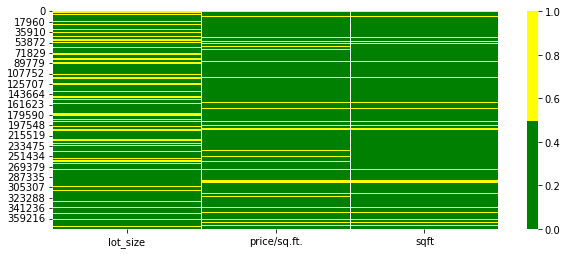

In [94]:
# Некоторые значения все еще отсутствуют.

cols_null_persent = data.isnull().mean() * 100
cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
display(cols_with_null)

colors = ['green', 'yellow']
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [95]:
# Чтобы заполнить недостающие значения, сгруппируем данные по 'property_Type', 'street', 'baths', 'beds', 'state', и 'city_size'.
grouped_data = data.groupby(['property_type', 'street', 'baths', 'beds', 'state', 'city_size'])
# Используем функцию "transform", чтобы вычислить средние значения для каждой группы и заполнить пробелы.
data['sqft'] = grouped_data['sqft'].transform(lambda x: x.fillna(x.mean()))
data['lot_size'] = grouped_data['lot_size'].transform(lambda x: x.fillna(x.mean()))
data['price/sq.ft.'] = grouped_data['price/sq.ft.'].transform(lambda x: x.fillna(x.mean()))

In [96]:
# Проверим отсутствующие значения.
null_data = data.isnull().sum()
display(null_data[null_data > 0])

sqft            7065
lot_size        6307
price/sq.ft.    8058
dtype: int64

In [97]:
# Заполним остальные пропущенные значения средним значением.
data['sqft'] = data['sqft'].fillna(data['sqft'].mean())
data['lot_size'] = data['lot_size'].fillna(data['lot_size'].mean())
data['price/sq.ft.'] = data['price/sq.ft.'].fillna(data['price/sq.ft.'].mean())

In [98]:
data.head()

,status,property_type,street,baths,fireplace,sqft,beds,state,stories,private_pool,...,remodeled_year,heating,cooling,parking,lot_size,price/sq.ft.,city_size,school_count,schools_rating_ave,schools_distance_ave
0,contingent,house,lane,3,1,2900.000000,4,NC,no data,0,...,no data,air,no data,no data,19294.665455,144.000000,medium,8,5.20,5.54
1,active,house,avenue,3,0,1947.000000,3,WA,1,0,...,no data,no data,no data,no data,5828.000000,159.000000,medium,3,4.00,1.33
2,active,house,street,2,1,3000.000000,3,CA,1,1,...,before 2000,air,central,garage,8626.000000,965.000000,large,3,6.00,1.96
3,active,house,street,8,1,6457.000000,5,TX,1,0,...,2000s,air,central,garage,8220.000000,371.000000,large,4,9.33,0.75
4,active,land,street,2,0,86340.105263,no data,FL,no data,0,...,no data,no data,no data,no data,10019.000000,384.702703,medium,3,4.50,4.08


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374554 entries, 0 to 377184
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                374554 non-null  object 
 1   property_type         374554 non-null  object 
 2   street                374554 non-null  object 
 3   baths                 374554 non-null  int16  
 4   fireplace             374554 non-null  int8   
 5   sqft                  374554 non-null  float64
 6   beds                  374554 non-null  object 
 7   state                 374554 non-null  object 
 8   stories               374554 non-null  object 
 9   private_pool          374554 non-null  int64  
 10  target                374554 non-null  int64  
 11  year_built            374554 non-null  object 
 12  remodeled_year        374554 non-null  object 
 13  heating               374554 non-null  object 
 14  cooling               374554 non-null  object 
 15  

## 4) Предварительный анализ данных - Часть 2
Качество модели должно повыситься, если:
* Удалите выбросы в данных.
* Преобразуйте целевой объект из логнормального в нормальное распределение, используя логарифм.

In [100]:
data.describe()

,baths,fireplace,sqft,private_pool,target,lot_size,price/sq.ft.,school_count,schools_rating_ave,schools_distance_ave
count,374554.000000,374554.000000,3.745540e+05,374554.000000,3.745540e+05,3.745540e+05,3.745540e+05,374554.000000,374554.000000,374554.000000
mean,2.466915,0.263217,9.950255e+03,0.118194,6.449333e+05,1.294760e+05,1.374579e+03,4.313245,5.214467,2.829497
std,1.114381,0.440380,1.500919e+06,0.322838,1.841700e+06,7.934837e+06,4.179566e+04,4.614031,2.068125,5.874368
min,0.000000,0.000000,1.000000e+02,0.000000,1.000000e+03,1.000000e+02,0.000000e+00,0.000000,1.000000,0.000000
25%,2.000000,0.000000,1.360000e+03,0.000000,1.870000e+05,5.698000e+03,1.270000e+02,3.000000,3.500000,1.030000
50%,2.000000,0.000000,1.970000e+03,0.000000,3.200000e+05,9.888000e+03,1.890000e+02,3.000000,5.026959,1.760000
75%,3.000000,1.000000,2.925875e+03,0.000000,5.828892e+05,2.190591e+04,3.400000e+02,5.000000,6.500000,3.250000
max,9.000000,1.000000,7.959794e+08,1.000000,1.950000e+08,2.147484e+09,5.950000e+06,65.000000,10.000000,1590.830000


In [101]:
# Создадим копию данных, чтобы упростить работу с изменениями в таблице.
temp_data = data.copy()

In [102]:
# Создадим список числовых признаков.
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['baths',
 'fireplace',
 'sqft',
 'private_pool',
 'target',
 'lot_size',
 'price/sq.ft.',
 'school_count',
 'schools_rating_ave',
 'schools_distance_ave']

In [103]:
# Создадим список категориальных признаков.
cat_features = list(types[(types == 'object')].index)
cat_features

['status',
 'property_type',
 'street',
 'beds',
 'state',
 'stories',
 'year_built',
 'remodeled_year',
 'heating',
 'cooling',
 'parking',
 'city_size']

Внимательно посмотрим на категориальные признаки.

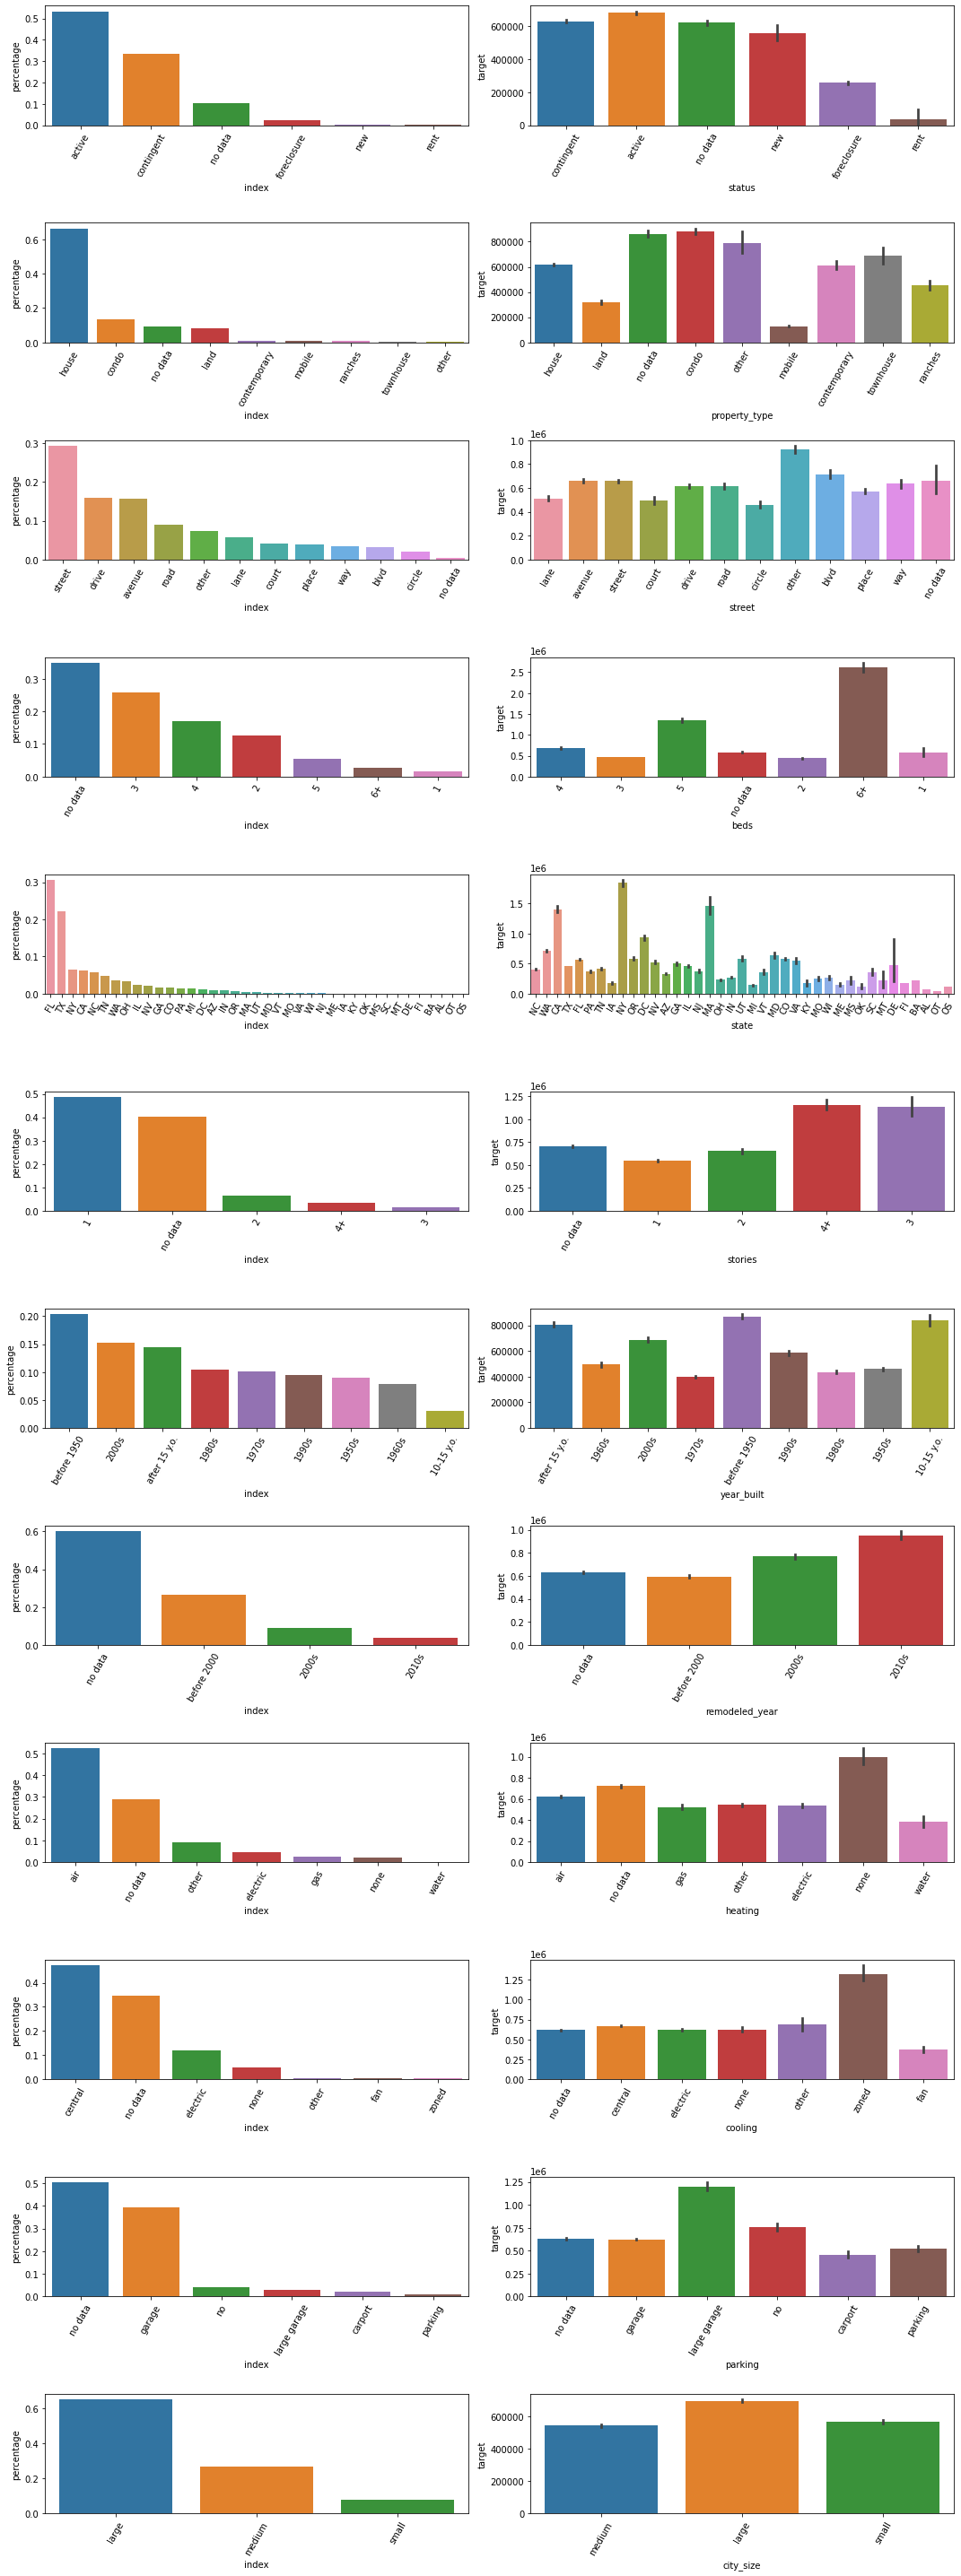

In [104]:
# Создадим вложенные графики с общим количеством n строк и 2 столбцов.
n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize=(15, 40))
# Выполним итерацию по каждому категориальному признаку.
for i, feature in enumerate(cat_features):
    # Создадим гистограмму, показывающую количество каждой категории в признаке.
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    # Создадим гистограмму, показывающую среднее целевое значение для каждой категории в признаке.
    mean_barplot = sns.barplot(data=data, x=feature, y='target', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout()

## 5) Feature Engineering
Исследуем логарифмические распределения выбросов, используя метод z-отклонения (три сигмы).

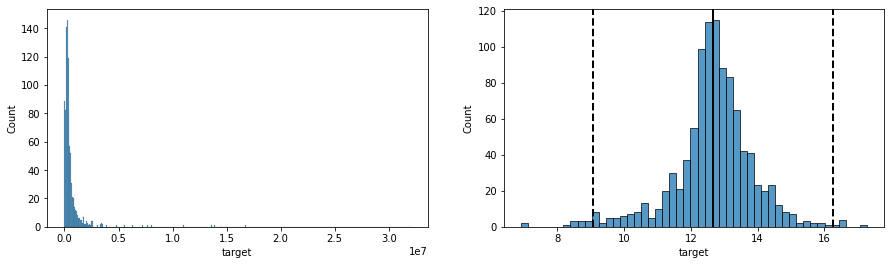

In [105]:
# Проиллюстрируем с использованием выборки из 1000 случайно выбранных значений.
sample_size = 1000
sample = temp_data.sample(sample_size)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
# Создадим гистограмму.
sns.histplot(data=sample, x='target', ax=axes[0])
# Логарифм.
log_target = np.log(sample['target'])
# Создадим гистограмму в логарифмическом масштабе.
sns.histplot(data=log_target, ax=axes[1])

# Добавим вертикальные линии для среднего значения и 2 для стандартного отклонения слева и справа от среднего значения.
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean() + 3*log_target.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean() - 3*log_target.std(),
                color='k', ls='--', lw=2);

In [106]:
# Вычислим среднее значение.
average = temp_data['schools_distance_ave'].mean()

# Заменим все значения 0 на среднее значение.
temp_data['schools_distance_ave'] = temp_data['schools_distance_ave'].replace(0, average)

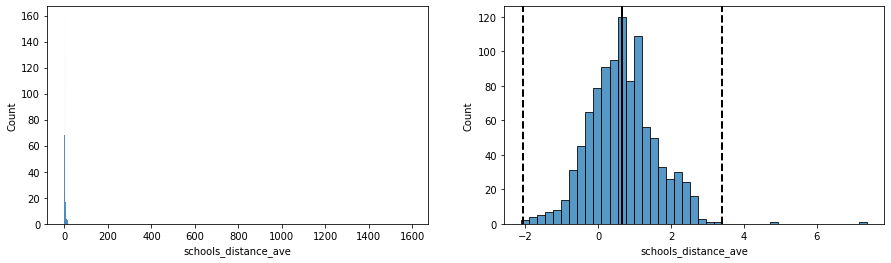

In [107]:
sample_size = 1000
sample = temp_data.sample(sample_size)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(data=sample, x='schools_distance_ave', ax=axes[0])

log_sqft = np.log(sample['schools_distance_ave'])
sns.histplot(data=log_sqft, ax=axes[1])

axes[1].axvline(log_sqft.mean(), color='k', lw=2)
axes[1].axvline(log_sqft.mean() + 3*log_sqft.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_sqft.mean() - 3*log_sqft.std(),
                color='k', ls='--', lw=2);

In [108]:
# Вычислим среднее значение.
average = temp_data['sqft'].mean()

# Заменим все значения 0 на среднее значение.
temp_data['sqft'] = temp_data['sqft'].replace(0, average)

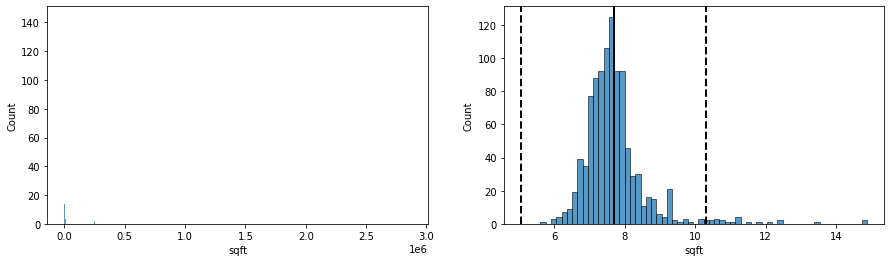

In [109]:
sample_size = 1000
sample = temp_data.sample(sample_size)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(data=sample, x='sqft', ax=axes[0])

log_sqft = np.log(sample['sqft'])
sns.histplot(data=log_sqft, ax=axes[1])

axes[1].axvline(log_sqft.mean(), color='k', lw=2)
axes[1].axvline(log_sqft.mean() + 3*log_sqft.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_sqft.mean() - 3*log_sqft.std(),
                color='k', ls='--', lw=2);

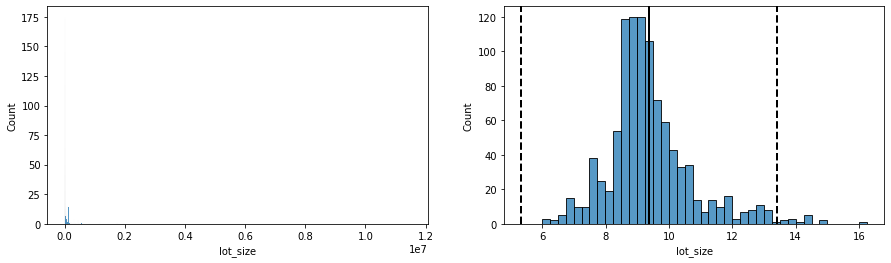

In [110]:
sample_size = 1000
sample = temp_data.sample(sample_size)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(data=sample, x='lot_size', ax=axes[0])

log_lot_size = np.log(sample['lot_size'])
sns.histplot(data=log_lot_size, ax=axes[1])

axes[1].axvline(log_lot_size.mean(), color='k', lw=2)
axes[1].axvline(log_lot_size.mean() + 3*log_lot_size.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_lot_size.mean() - 3*log_lot_size.std(),
                color='k', ls='--', lw=2);

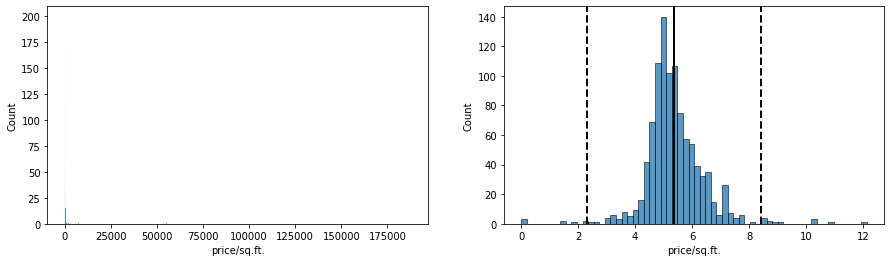

In [111]:
# Вычислим среднее значение.
average = temp_data['price/sq.ft.'].mean()

# Заменим все значения 0 на среднее значение.
temp_data['price/sq.ft.'] = temp_data['price/sq.ft.'].replace(0, average)

sample_size = 1000
sample = temp_data.sample(sample_size)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(data=sample, x='price/sq.ft.', ax=axes[0])

log_price = np.log(sample['price/sq.ft.'])
sns.histplot(data=log_price, ax=axes[1])

axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean() + 3*log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean() - 3*log_price.std(),
                color='k', ls='--', lw=2);

Удалим выбросы, используя метод z-отклонения для логарифмических объектов.

In [112]:
# Создадим функцию, фильтрующую выбросы, используя метод z-отклонения.
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3*sigma
    upper_bound = mu + 3*sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
# Удалим выбросы.
outliers, temp_cleaned = outliers_z_score(temp_data, 'target', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'schools_distance_ave', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'lot_size', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'price/sq.ft.', log_scale=True)
print('Shape before cleaning outliers: {}'.format(temp_data.shape))
print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))

Shape before cleaning outliers: (374554, 22)
Shape after cleaning outliers: (350719, 22)


In [113]:
temp_cleaned.describe(include='all')

,status,property_type,street,baths,fireplace,sqft,beds,state,stories,private_pool,...,remodeled_year,heating,cooling,parking,lot_size,price/sq.ft.,city_size,school_count,schools_rating_ave,schools_distance_ave
count,350719,350719,350719,350719.000000,350719.000000,350719.000000,350719,350719,350719,350719.000000,...,350719,350719,350719,350719,350719.000000,350719.000000,350719,350719.000000,350719.000000,350719.000000
unique,6,9,12,NaN,NaN,NaN,7,38,5,NaN,...,4,7,7,6,NaN,NaN,3,NaN,NaN,NaN
top,active,house,street,NaN,NaN,NaN,no data,FL,1,NaN,...,no data,air,central,no data,NaN,NaN,large,NaN,NaN,NaN
freq,185220,242530,103226,NaN,NaN,NaN,114400,106631,177132,NaN,...,203581,191057,173155,169405,NaN,NaN,229329,NaN,NaN,NaN
mean,NaN,NaN,NaN,2.482303,0.274753,2542.559527,NaN,NaN,NaN,0.121265,...,NaN,NaN,NaN,NaN,28564.079335,291.703986,NaN,4.237715,5.231041,2.716650
std,NaN,NaN,NaN,1.101160,0.446390,2442.580582,NaN,NaN,NaN,0.326436,...,NaN,NaN,NaN,NaN,65148.227884,296.113997,NaN,4.497316,2.075348,2.755423
min,NaN,NaN,NaN,0.000000,0.000000,178.000000,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,187.000000,15.000000,NaN,0.000000,1.000000,0.020000
25%,NaN,NaN,NaN,2.000000,0.000000,1344.000000,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,5636.000000,128.000000,NaN,3.000000,3.500000,1.050000
50%,NaN,NaN,NaN,2.000000,0.000000,1933.000000,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,9545.000000,188.000000,NaN,3.000000,5.026959,1.760000
75%,NaN,NaN,NaN,3.000000,1.000000,2818.000000,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,20073.850000,332.000000,NaN,5.000000,6.500000,3.120000


Создадим тепловую карту для оценки мультиколлинеарной зависимости и линейной взаимосвязи между факторами и целевым объектом.

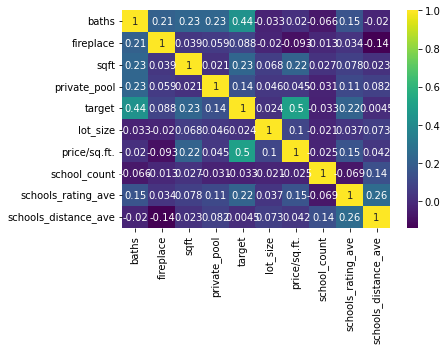

In [114]:
# Корреляционная тепловая карта.
fig = plt.figure()
sns.heatmap(temp_cleaned.corr(), annot=True, cmap='viridis');

Кодирование текстовых категориальных признаков.

In [115]:
# Двоичное кодирование признака 'state'.

bin_encoder = ce.BinaryEncoder(cols=['state'])
type_bin = bin_encoder.fit_transform(temp_cleaned['state'])
temp_encoded = pd.concat([temp_cleaned, type_bin], axis=1)
temp_encoded = temp_encoded.drop('state', axis=1)

In [116]:
# Ординарное кодирование 'beds', 'stories', 'year_built', 'remodeled_year', и 'city_size'.

# Инициализируем кодировщик.
encoder = OrdinalEncoder()

# Закодируем столбцы и сохраним преобразованные данные в новом фрейме данных.
data_encoded = temp_encoded.copy()
columns_to_encode = ['beds', 'stories', 'year_built', 'remodeled_year', 'city_size']
data_encoded[columns_to_encode] = encoder.fit_transform(temp_encoded[columns_to_encode])

# Удалим исходные столбцы.
data_encoded = data_encoded.drop(columns_to_encode, axis=1)

In [117]:
# Кодирование категориальных признаков.
data_new = pd.get_dummies(data_encoded)
data_new.head()

,baths,fireplace,sqft,private_pool,target,lot_size,price/sq.ft.,school_count,schools_rating_ave,schools_distance_ave,...,cooling_no data,cooling_none,cooling_other,cooling_zoned,parking_carport,parking_garage,parking_large garage,parking_no,parking_no data,parking_parking
0,3,1,2900.0,0,418000,19294.665455,144.0,8,5.200000,5.540000,...,1,0,0,0,0,0,0,0,1,0
1,3,0,1947.0,0,310000,5828.000000,159.0,3,4.000000,1.330000,...,1,0,0,0,0,0,0,0,1,0
2,2,1,3000.0,1,2895000,8626.000000,965.0,3,6.000000,1.960000,...,0,0,0,0,0,1,0,0,0,0
3,8,1,6457.0,0,2395000,8220.000000,371.0,4,9.330000,0.750000,...,0,0,0,0,0,1,0,0,0,0
5,2,0,897.0,0,209000,680.000000,233.0,0,5.026959,2.829497,...,0,0,0,0,0,0,0,0,1,0


In [118]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350719 entries, 0 to 377184
Data columns (total 63 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       350719 non-null  int16  
 1   fireplace                   350719 non-null  int8   
 2   sqft                        350719 non-null  float64
 3   private_pool                350719 non-null  int64  
 4   target                      350719 non-null  int64  
 5   lot_size                    350719 non-null  float64
 6   price/sq.ft.                350719 non-null  float64
 7   school_count                350719 non-null  int64  
 8   schools_rating_ave          350719 non-null  float64
 9   schools_distance_ave        350719 non-null  float64
 10  state_0                     350719 non-null  int64  
 11  state_1                     350719 non-null  int64  
 12  state_2                     350719 non-null  int64  
 13  state_3       

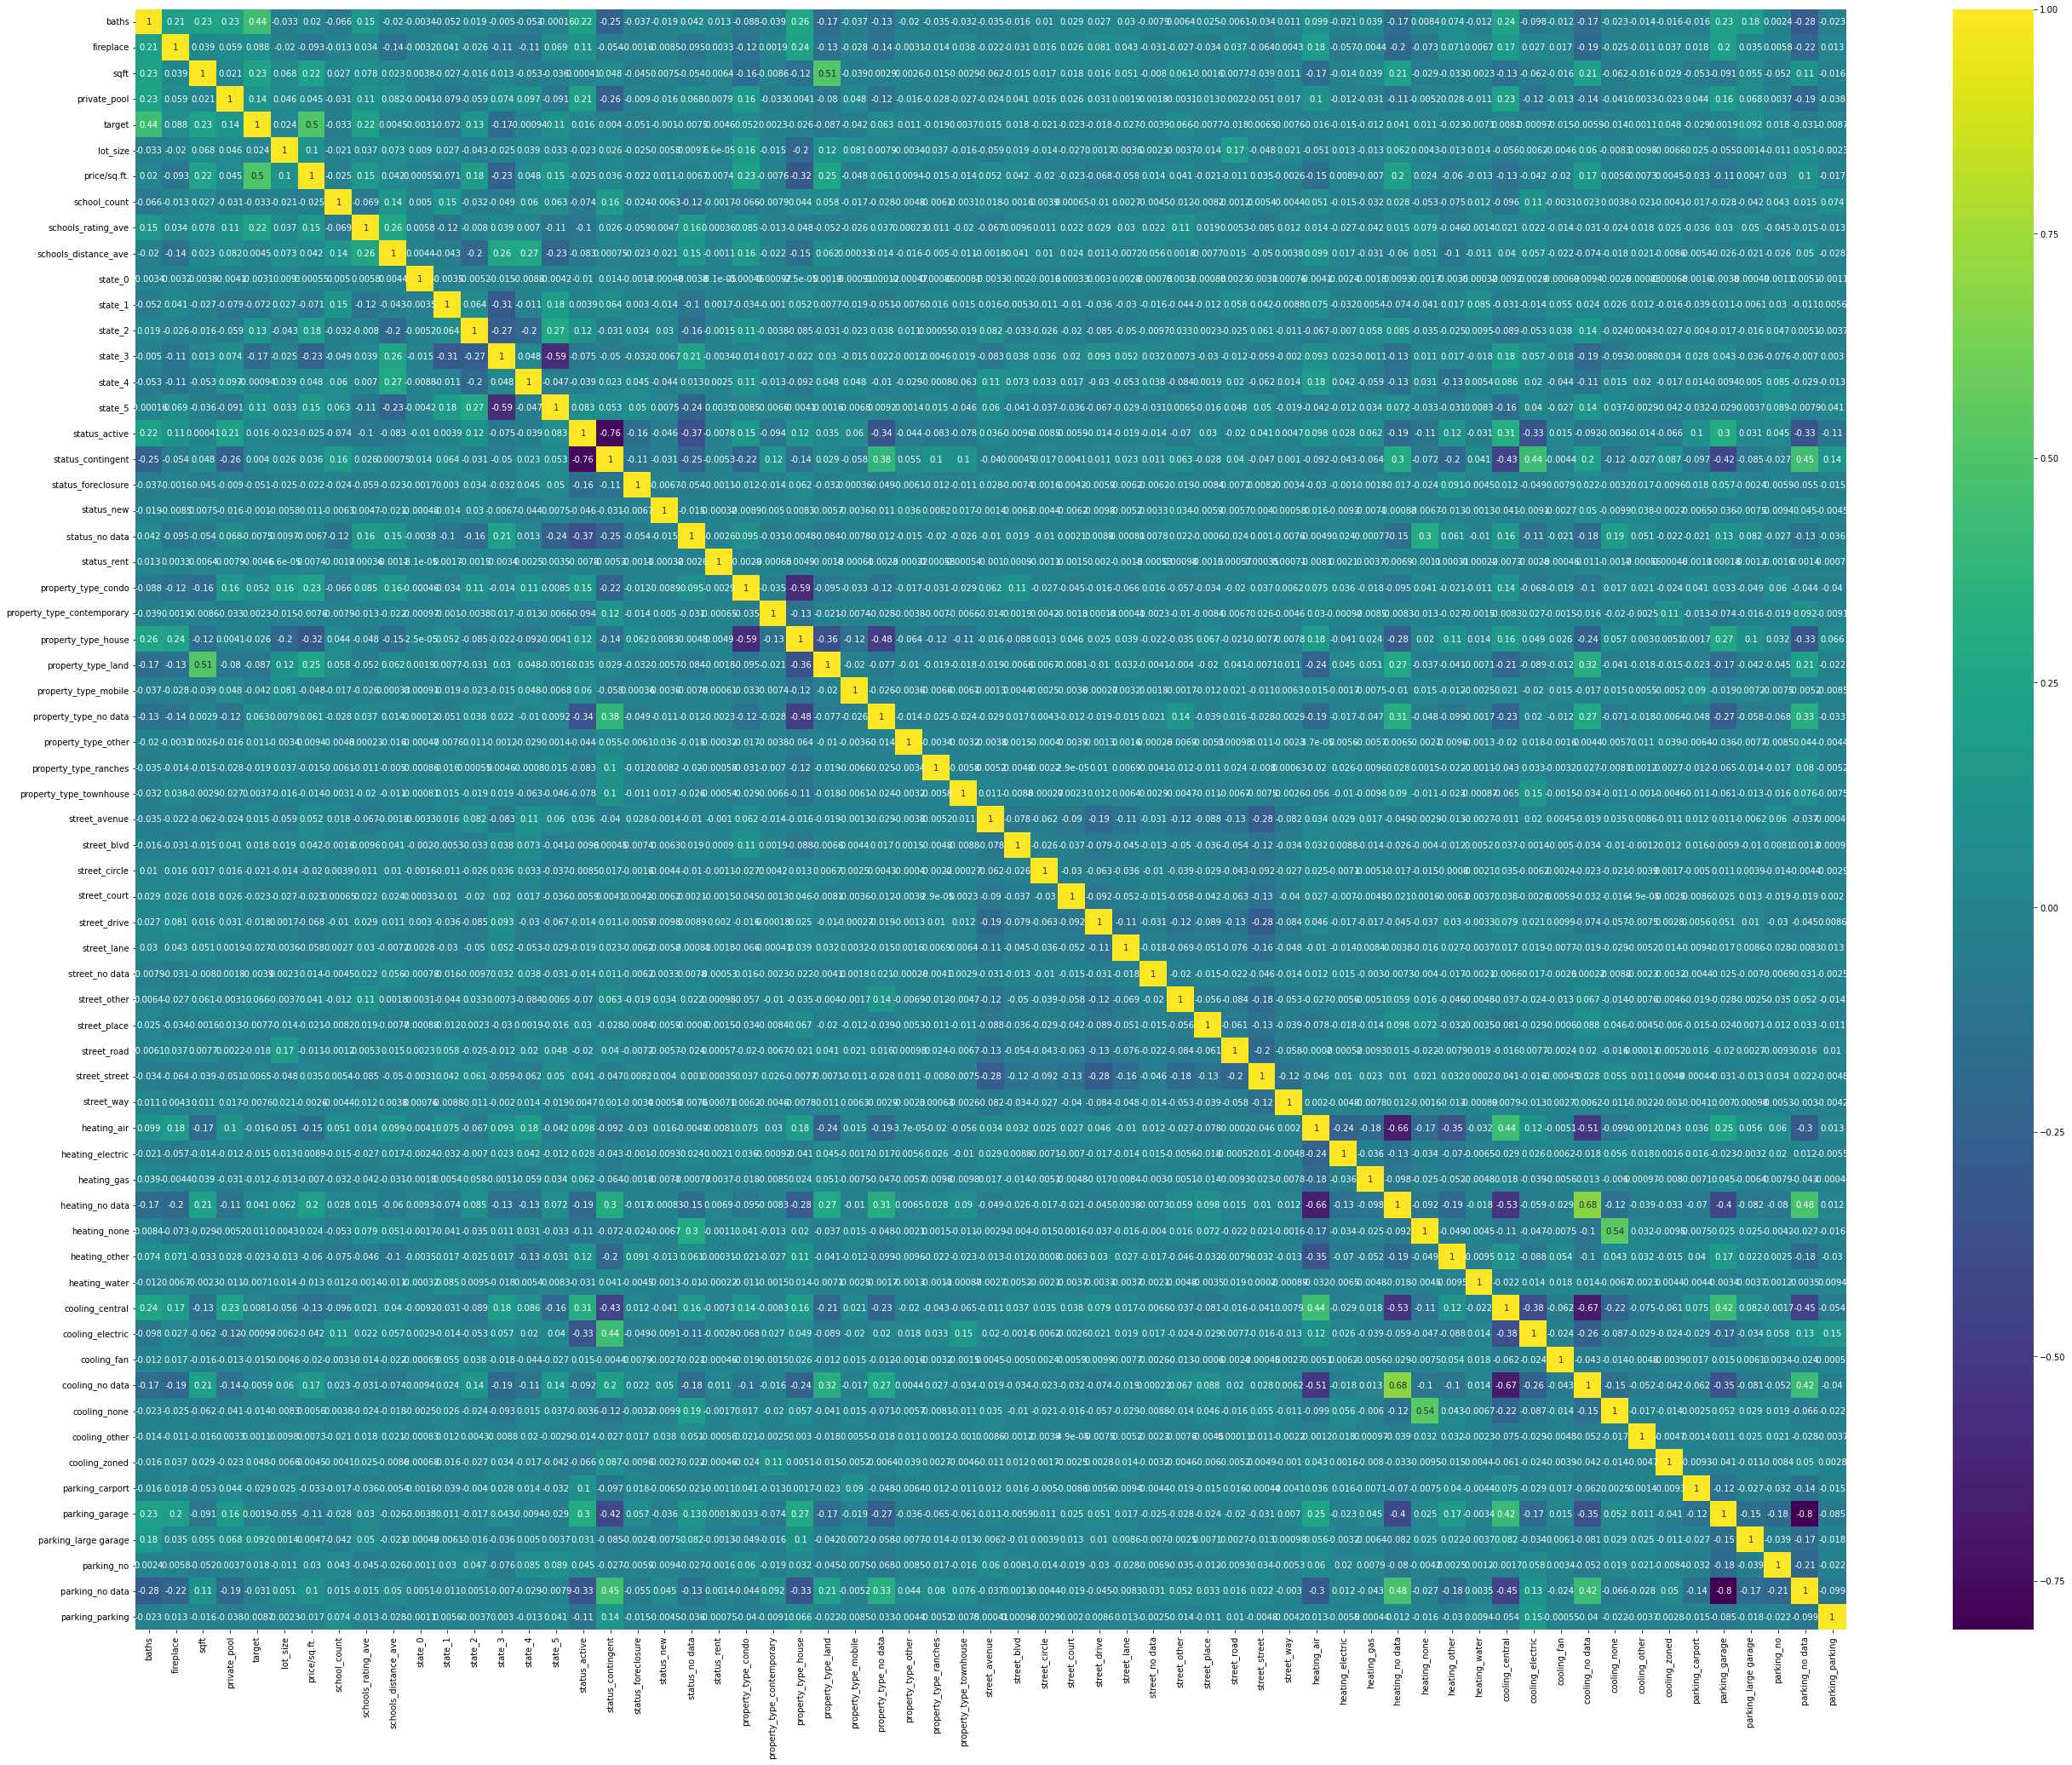

In [119]:
# Корреляционная тепловая карта.
fig = plt.figure(figsize=(45, 35))
sns.heatmap(data_new.corr(), annot=True, cmap='viridis');

In [120]:
# Разделим набор данных на обучающие X и тестовые y.
X = data_new.drop('target', axis=1)
y = data_new['target']

# В пропорции 80/20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (280575, 62)
Test shape: (70144, 62)


На данный момент у нас довольно много признаков: скорее всего, не все из них будут важны. Давайте оставим только те, которые наиболее связаны с целевой переменной и, безусловно, будут способствовать улучшению качества модели.

Используя SelectKBest, мы выбираем 25 признаков, которые лучше всего подходят для прогнозирования целевой переменной в логарифмическом масштабе. Мы реализуем отбор на основе обучающей выборки, используя параметр score_func = f_regression.

In [121]:
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train)

best_features = selector.get_feature_names_out()
best_features

array(['baths', 'fireplace', 'sqft', 'private_pool', 'lot_size',
       'price/sq.ft.', 'school_count', 'schools_rating_ave', 'state_1',
       'state_2', 'state_3', 'state_5', 'status_foreclosure',
       'property_type_condo', 'property_type_house', 'property_type_land',
       'property_type_mobile', 'property_type_no data', 'street_lane',
       'street_other', 'heating_no data', 'cooling_zoned',
       'parking_carport', 'parking_large garage', 'parking_no data'],
      dtype=object)

In [122]:
X_train = X_train[best_features]
X_test = X_test[best_features]

Нормализуем предикторы в обучающем и тестовом наборах с помощью MinMaxScaler.

In [123]:
col_names = list(X_train.columns)

mm_scaler = preprocessing.MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

## 6) Моделирование
**Показатели оценки**

Создайте функцию для вычисления показателей:
1. MAE - Средняя абсолютная ошибка (какова средняя разница между реальной и прогнозируемой ценой)
2. MAPE - Средняя абсолютная процентная ошибка (какова средняя разница между реальной и прогнозируемой ценой в %)
3. \\(R^2\\) - коэффициент детерминации (чем ближе к 1, тем лучше. Оценка выше 0,5 - это хорошо)

In [124]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('Train R^2: {:.2f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('\n')
    print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    print('Test R^2: {:.2f}'.format(metrics.r2_score(y_test, y_test_predict)))

---
**Baseline - средние значения**

Что, если мы просто дадим среднюю цену недвижимости в качестве ответа?

In [125]:
# Вычислим среднее значение y_train и_test.
y_train_naive = np.mean(y_train)
y_test_naive = np.mean(y_test)

y_train_pred_naive = np.full(len(y_train), y_train_naive)
y_test_pred_naive = np.full(len(y_test), y_test_naive)

print_metrics(y_train, y_train_pred_naive, y_test, y_test_pred_naive)

Train MAE: 455085.95
Train MAPE: 240.68%
Train R^2: 0.00


Test MAE: 457380.98
Test MAPE: 241.69%
Test R^2: 0.00


Результаты очень плохие. Мы должны попробовать другие методы.

---
**Линейная регрессия.**

In [126]:
# Создадим логарифмическую целевую цену.
y_train_log = np.log(y_train)

# Инициализируем объект линейной регрессии.
lr = LinearRegression()
# Обучим модель.
lr.fit(X_train_scaled, y_train_log)

# Предскажем результат.
# Поскольку мы обучали модель с использованием логарифма, мы должны взять экспоненту результата (np.exp).
y_train_pred = np.exp(lr.predict(X_train_scaled))
y_test_pred = np.exp(lr.predict(X_test_scaled))

# Покажем метрики.
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train MAE: 257052.03
Train MAPE: 67.45%
Train R^2: 0.13


Test MAE: 256572.22
Test MAPE: 69.30%
Test R^2: 0.08


Результаты значительно лучше, чем исходные.

Давайте попробуем другую модель.

---
**Light Gradient Boosted Machine Regressor**

In [127]:
# Создадим логарифмическую целевую цену.
y_train_log = np.log(y_train)

# Инициализируем LGBM Regressor объект.
lightgbm = LGBMRegressor(objective='regression', 
                        n_estimators=400,
                        max_bin=250,
                        num_leaves=10,
                        bagging_seed=10,
                        feature_fraction_seed=2,
                        learning_rate=0.01, 
                        verbose=-1,
                        random_state=42)

# Обучим модель.
lightgbm.fit(X_train_scaled, y_train_log)

# Предскажем результат.
y_train_pred = np.exp(lightgbm.predict(X_train_scaled))
y_test_pred = np.exp(lightgbm.predict(X_test_scaled))

# Покажеи метрики.
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train MAE: 146396.54
Train MAPE: 33.87%
Train R^2: 0.64


Test MAE: 148652.13
Test MAPE: 34.58%
Test R^2: 0.63


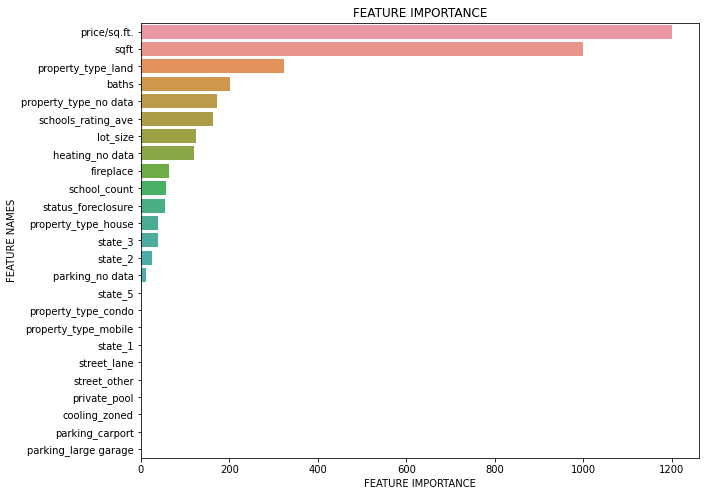

In [128]:
# Покажем важность признаков.
feature_importance = np.array(lightgbm.feature_importances_)
feature_names = np.array(X_train_scaled.columns)

# Создадим DataFrame, используя словарь.
data={'feature_names': feature_names, 'feature_importance': feature_importance}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Определим размер столбчатой диаграммы.
plt.figure(figsize=(10,8))
# Построим столбчатую диаграмму.
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
# Добавим метки диаграммы.
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');

---
**Gradient Boosting**

In [129]:
# Инициализируем GradientBoostingRegressor объект.
gbr = GradientBoostingRegressor(n_estimators=400,
                                min_samples_leaf=10,
                                min_samples_split=9,
                                random_state=42)

# Обучим модель.
gbr.fit(X_train_scaled, y_train_log)

# Предскажем результат.
y_train_pred = np.exp(gbr.predict(X_train_scaled))
y_test_pred = np.exp(gbr.predict(X_test_scaled))

# Покажем метрики.
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train MAE: 98255.60
Train MAPE: 24.87%
Train R^2: 0.80


Test MAE: 101177.02
Test MAPE: 25.72%
Test R^2: 0.78


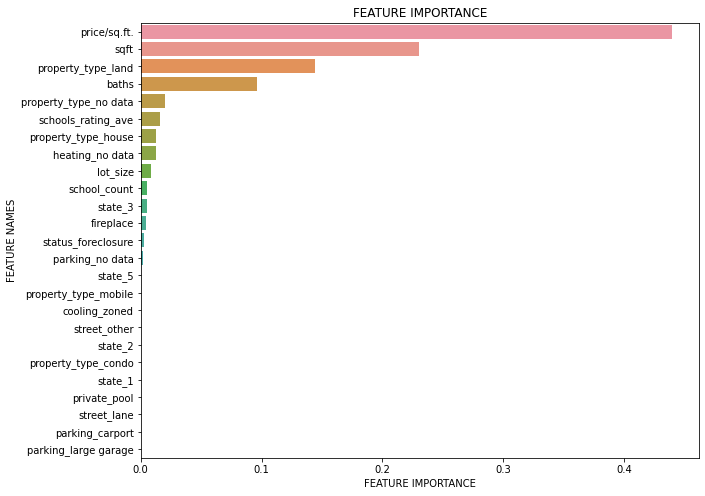

In [130]:
# Покажем важность признаков.
feature_importance = np.array(gbr.feature_importances_)
feature_names = np.array(X_train_scaled.columns)

# Создадим DataFrame, используя словарь.
data = {'feature_names': feature_names, 'feature_importance': feature_importance}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Определим размер столбчатой диаграммы.
plt.figure(figsize=(10,8))
# Построим столбчатую диаграмму.
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
# Добавим метки диаграммы.
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');

---
**Extreme Gradient Boosting**

In [131]:
# Инициализируем XGBRegressor объект.
xgboost = XGBRegressor(n_estimators=1000,
                        max_depth=7,
                        eta=0.1,
                        subsample=0.7,
                        colsample_bytree=0.8
)

# Обучим модель.
xgboost.fit(X_train_scaled, y_train_log)

# Предскажем результат.
y_train_pred = np.exp(xgboost.predict(X_train_scaled))
y_test_pred = np.exp(xgboost.predict(X_test_scaled))

# Покажем метрики.
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

[06:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train MAE: 60845.20
Train MAPE: 11.90%
Train R^2: 0.88


Test MAE: 74914.38
Test MAPE: 16.48%
Test R^2: 0.84


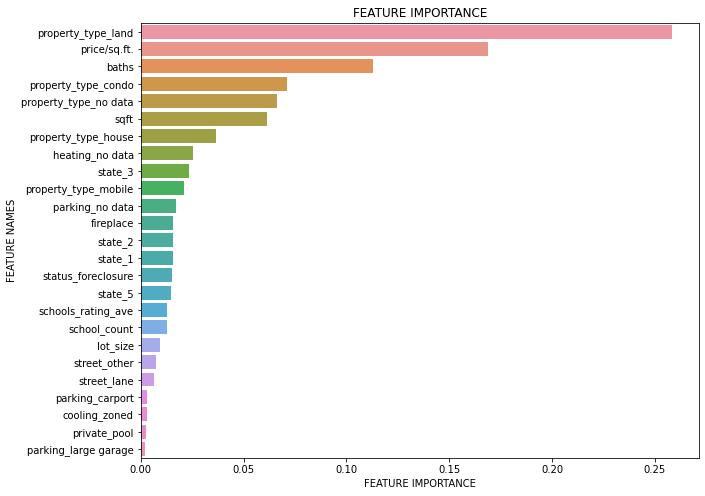

In [132]:
# Покажем важность признаков.
feature_importance = np.array(xgboost.feature_importances_)
feature_names = np.array(X_train_scaled.columns)

# Создадим DataFrame, используя словарь.
data = {'feature_names': feature_names, 'feature_importance': feature_importance}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Определим размер столбчатой диаграммы.
plt.figure(figsize=(10,8))
# Построим столбчатую диаграмму.
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
# Добавим метки диаграммы.
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');

---
**Random Forest**

In [133]:
# Создадим логарифмическую целевую цену.
y_train_log = np.log(y_train)

# Инициализируем RandomForestRegressor объект.
rfr = RandomForestRegressor(n_estimators=300,
                            max_depth=30,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            max_features=None,
                            oob_score=True,
                            random_state=42)

# Обучим модель.
rfr.fit(X_train_scaled, y_train_log)

# Предскажем результат.
y_train_pred = np.exp(rfr.predict(X_train_scaled))
y_test_pred = np.exp(rfr.predict(X_test_scaled))

# Покажем метрики.
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train MAE: 44463.62
Train MAPE: 8.23%
Train R^2: 0.88


Test MAE: 60650.60
Test MAPE: 14.92%
Test R^2: 0.85


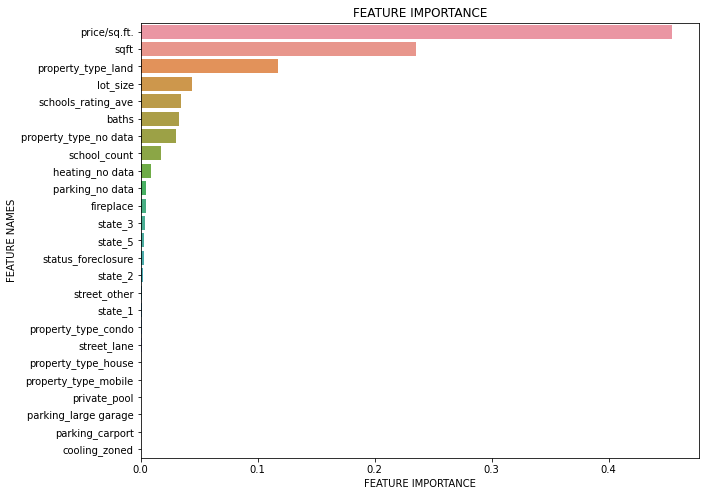

In [134]:
# Покажем важность признаков.
feature_importance = np.array(rfr.feature_importances_)
feature_names = np.array(X_train_scaled.columns)

# Создадим DataFrame, используя словарь.
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Определим размер столбчатой диаграммы.
plt.figure(figsize=(10,8))
# Построим столбчатую диаграмму.
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
# Добавим метки диаграммы.
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');

---
**Stacking Regressor**

In [135]:
# Создадим список кортежей, содержащий имя и объект для каждой модели.
base_models = [('lr', lr), ('lightgbm', lightgbm), ('gbr', gbr), ('xgboost', xgboost), ('rfr', rfr)]

# Создадим blending model.
blend_model = StackingRegressor(estimators=base_models)

# Обучим модель.
blend_model.fit(X_train_scaled, y_train_log)

# Предскажем результат.
y_train_pred = np.exp(blend_model.predict(X_train_scaled))
y_test_pred = np.exp(blend_model.predict(X_test_scaled))

# Покажем метрики.
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

[06:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:10:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:23:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train MAE: 51674.37
Train MAPE: 9.70%
Train R^2: 0.88


Test MAE: 65987.08
Test MAPE: 15.07%
Test R^2: 0.85


## 7) Results

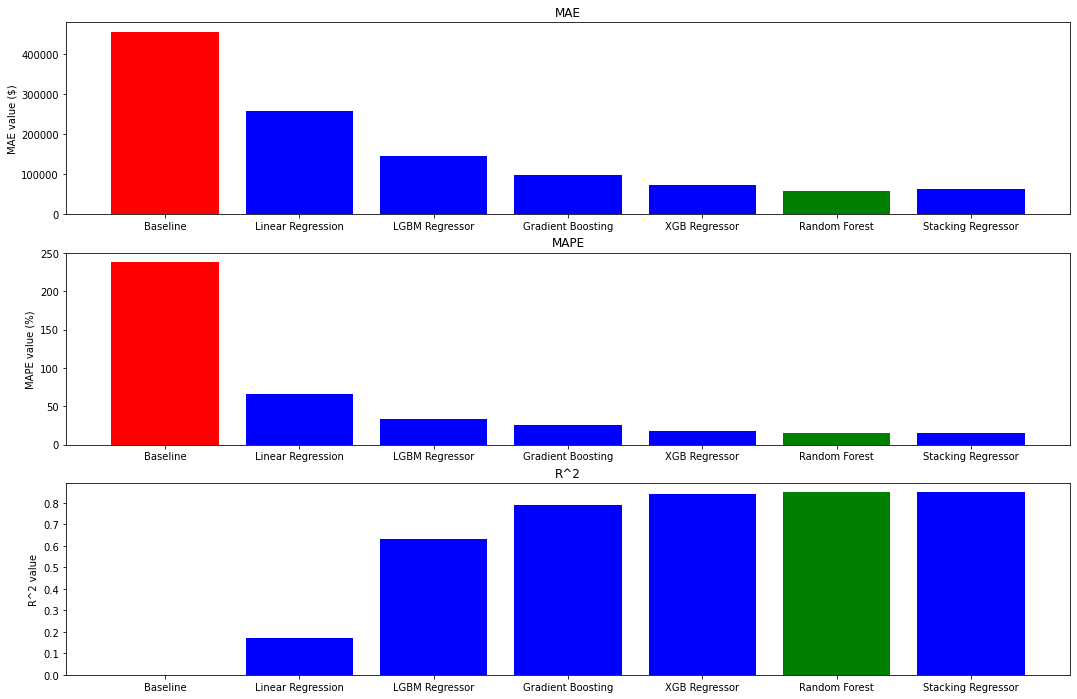

In [136]:
field_names = ['Baseline', 'Linear Regression', "LGBM Regressor", "Gradient Boosting",
               'XGB Regressor', 'Random Forest', 'Stacking Regressor']

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12))

# Извлеките данные для каждого измерения.
mae = [456644.02, 257411.30, 146723.93, 98464.57, 72074.98, 59434.88, 62981.36]
mape = [238.26, 65.81, 33.13, 25.30, 17.19, 15.47, 15.63]
r2 = [0.00, 0.17, 0.63, 0.79, 0.84, 0.85, 0.85]

# Create the bar plots
_ = ax1.bar(field_names, mae, color=['r', 'b', 'b', 'b', 'b', 'g', 'b'])
_ = ax2.bar(field_names, mape, color=['r', 'b', 'b', 'b', 'b', 'g', 'b'])
_ = ax3.bar(field_names, r2, color=['r', 'b', 'b', 'b', 'b', 'g', 'b'])

# Add title and labels to the plots
_ = ax1.set_title("MAE")
_ = ax1.set_ylabel("MAE value ($)")
_ = ax2.set_title("MAPE")
_ = ax2.set_ylabel("MAPE value (%)")
_ = ax3.set_title("R^2")
_ = ax3.set_ylabel("R^2 value")

# Show the plot
plt.show()

###Вывод
1. Наилучшие результаты показывает модель регрессора случайного леса. Средняя абсолютная погрешность составляет около 60 000 долларов, что довольно много. Тем не менее, это намного (почти в 10 раз) лучше, чем базовый уровень. Средняя абсолютная процентная погрешность составляет около 15%. Оценка R^2 (коэффициент детерминации) показывает относительно хорошие 0,85 (по шкале от -1 до 1).
2. В целом, исходный набор данных содержит множество проблем и несоответствий. Очистка и Feature Engineering были одной из главных целей этого проекта, который был успешно выполнен.
3. Другой целью этого проекта была демонстрация различных алгоритмов машинного обучения. Гиперпараметры для всех моделей были найдены с помощью Optuna, платформы оптимизации гиперпараметров. Мы оставили эти расчеты за пределами этой записной книжки, поскольку они отнимают довольно много времени.